In [1]:
using AlfvenDetectors
using PyPlot
using Flux
using BSON

In [2]:
datapath = "/home/vit/vyzkum/alfven/cdb_data/data_sample/"

"/home/vit/vyzkum/alfven/cdb_data/data_sample/"

In [3]:
shots = readdir(datapath)

16-element Array{String,1}:
 "Jldata10000.h5"
 "Jldata10001.h5"
 "Jldata10002.h5"
 "Jldata10003.h5"
 "Jldata10004.h5"
 "Jldata10005.h5"
 "Jldata10006.h5"
 "Jldata10007.h5"
 "Jldata10008.h5"
 "Jldata10370.h5"
 "Jldata10514.h5"
 "Jldata10800.h5"
 "Jldata10866.h5"
 "Jldata10870.h5"
 "Jldata10893.h5"
 "Jldata10975.h5"

In [4]:
shotno = 10893
filename = joinpath(datapath, "Jldata$(shotno).h5")

"/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10893.h5"

In [5]:
data = AlfvenDetectors.Float.(AlfvenDetectors.get_ft_signal(filename, AlfvenDetectors.readnormlogupsd));

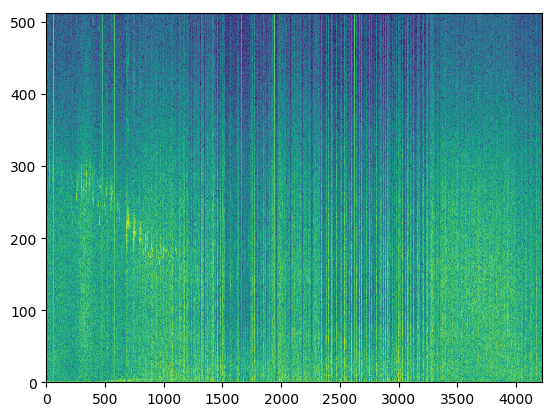

PyObject <matplotlib.collections.QuadMesh object at 0x7fec6eb6b9b0>

In [6]:
pcolormesh(data)

In [7]:
# now split the data into patches
function split_horizontal(data::AbstractArray,width)
    splits = collect(1:width:size(data,2))
    return map(x->data[:,x[1]:x[2]-1], zip(splits[1:end-1], splits[2:end]))
end
function split_horizontal(data::AbstractVector,width)
    splits = collect(1:width:size(data,2))
    return map(x->data[x[1]:x[2]-1], zip(splits[1:end-1], splits[2:end]))
end
"""
    reshape4conv(data::AbstractVector)

Reshape a vector of array into a M x N x 1 x L array.
"""
function reshape4conv(data::AbstractVector)
    res = Array{typeof(data[1][1]),4}(undef,size(data[1])...,1,length(data))
    for i in 1:length(data_split)
        res[:,:,1,i] = data_split[i]
    end
    return res
end


reshape4conv

In [8]:
width = 32
data_split = split_horizontal(data,width);
# make it a MxNx1xK array
data_array = reshape4conv(data_split);

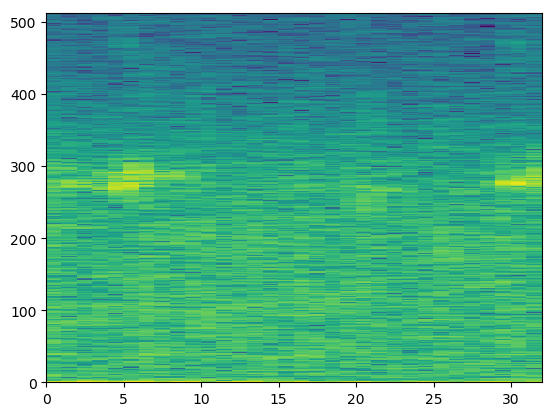

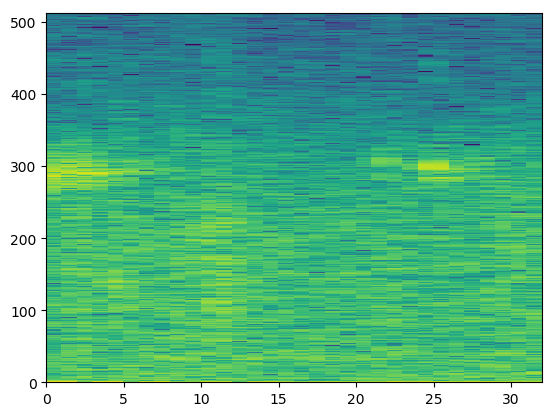

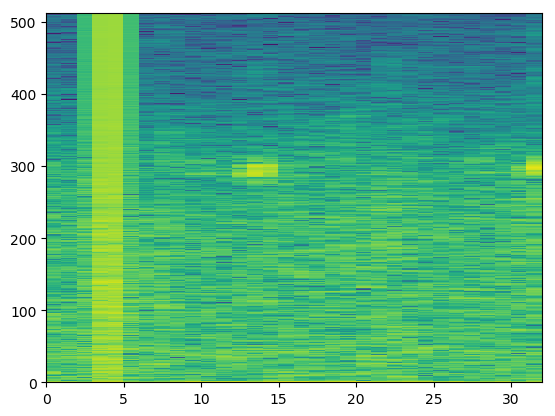

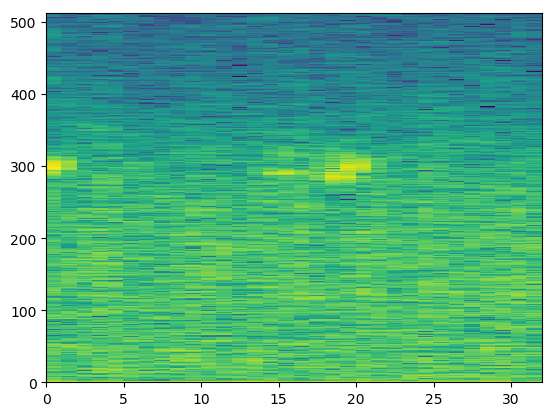

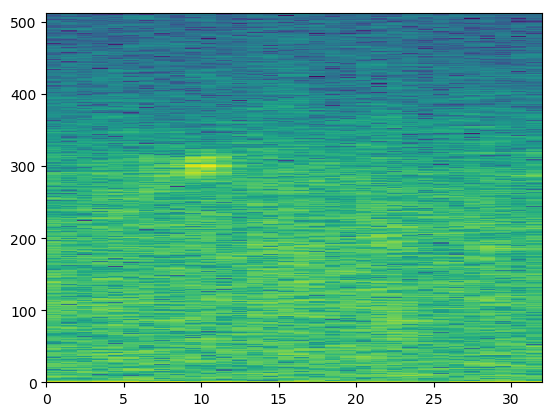

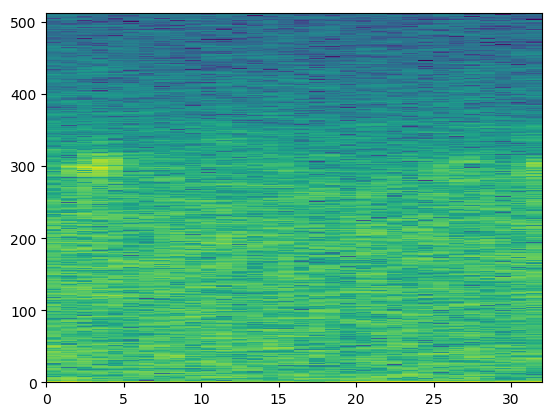

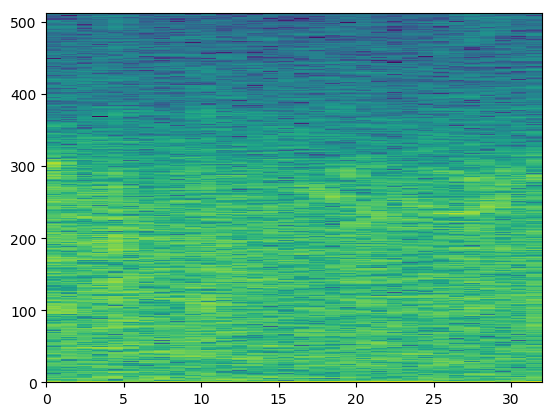

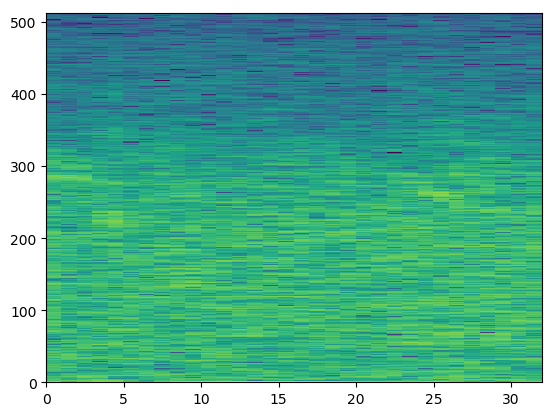

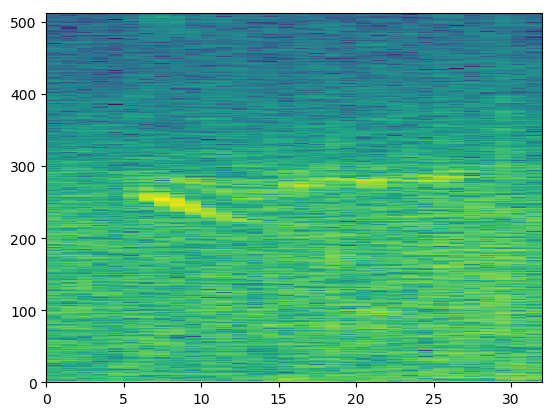

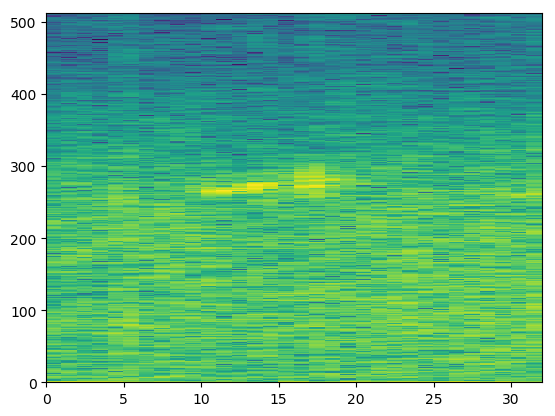

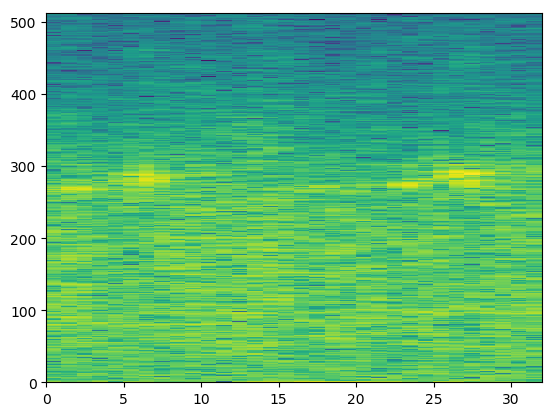

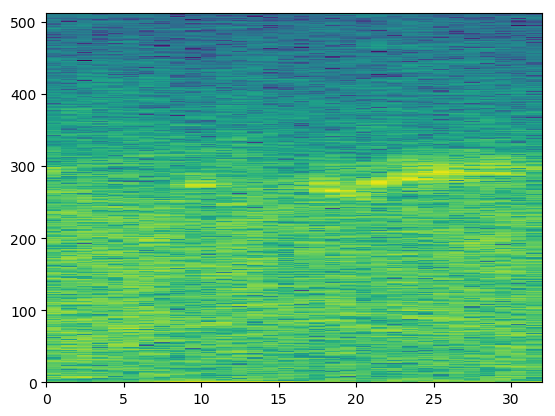

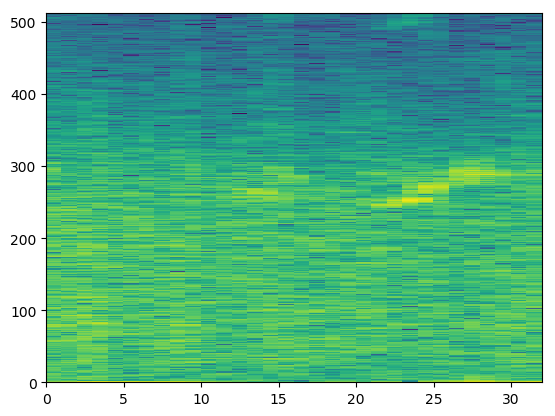

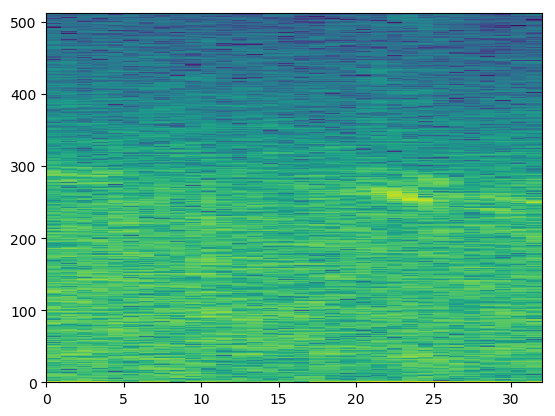

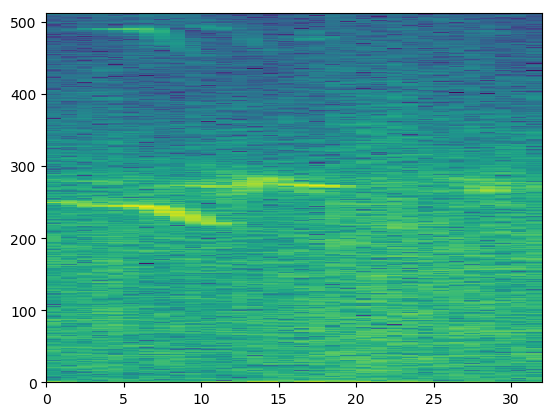

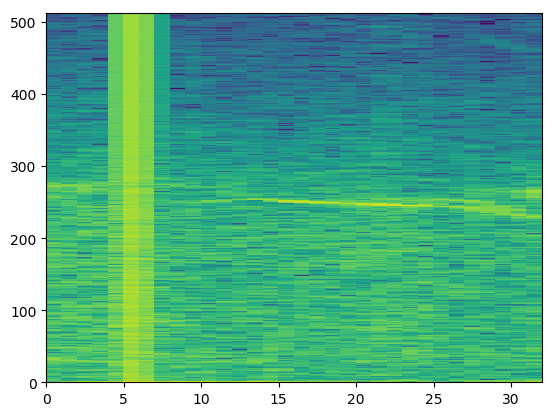

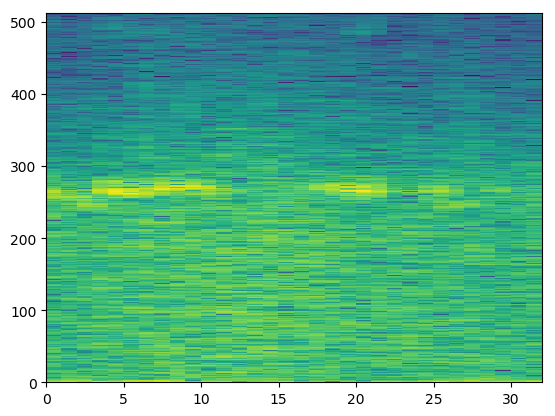

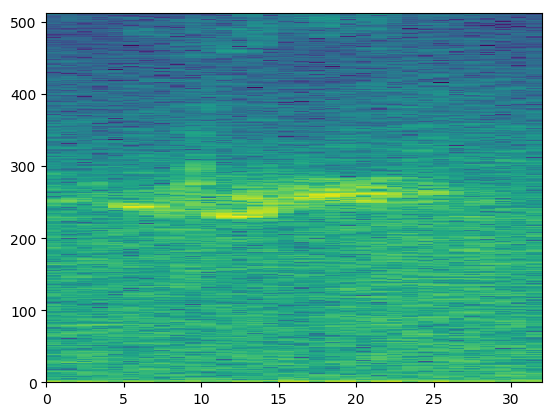

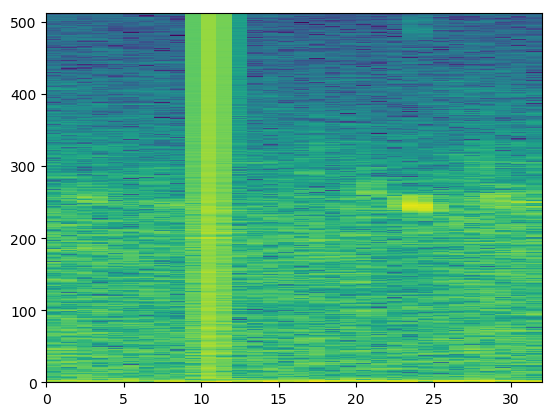

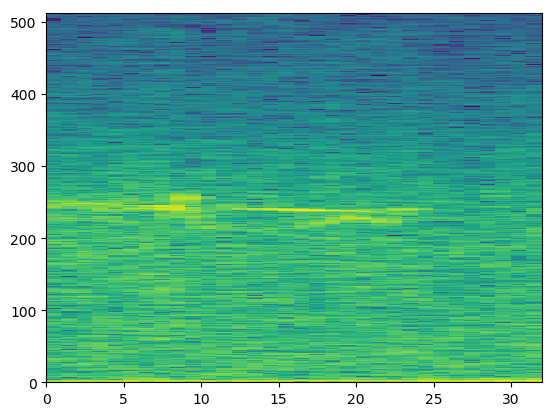

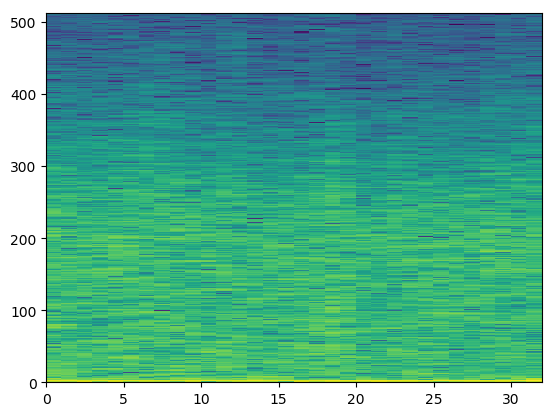

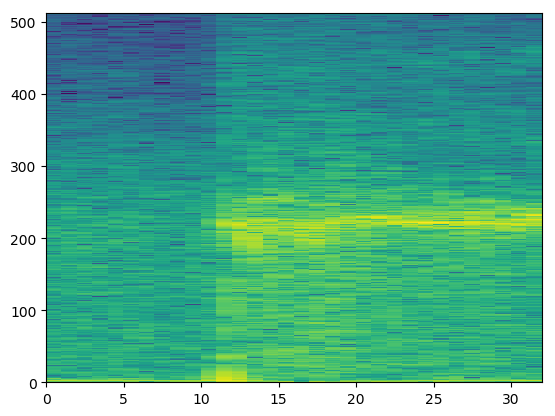

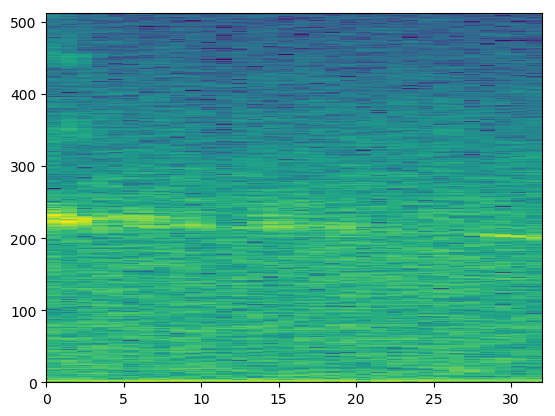

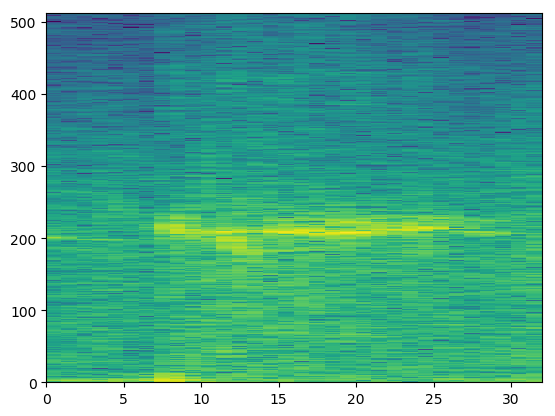

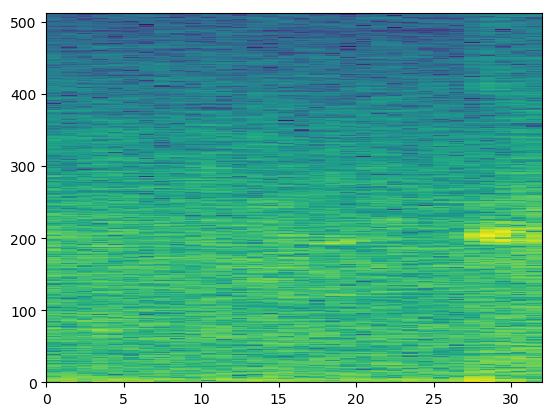

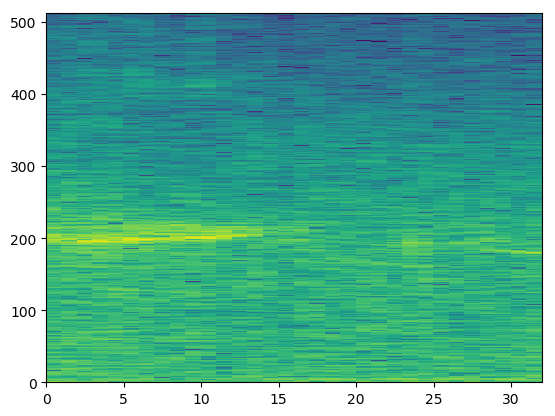

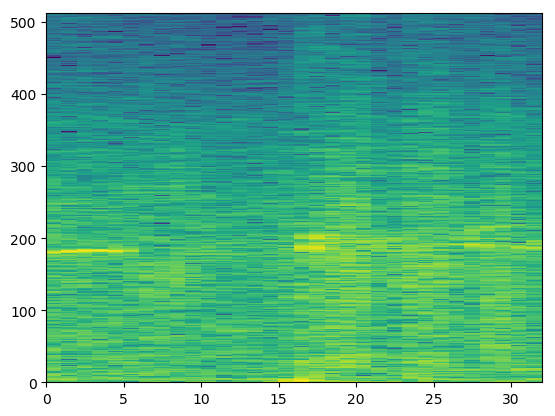

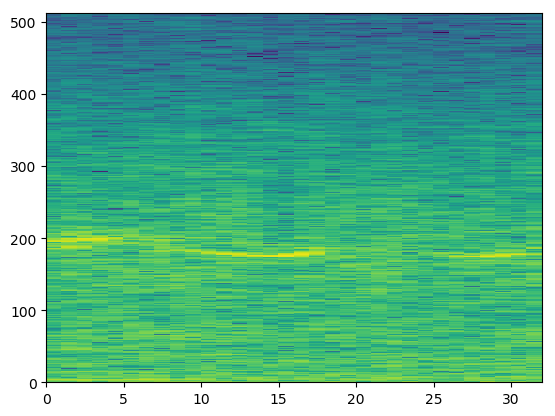

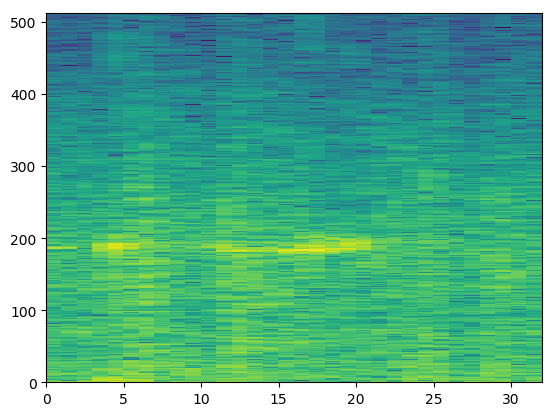

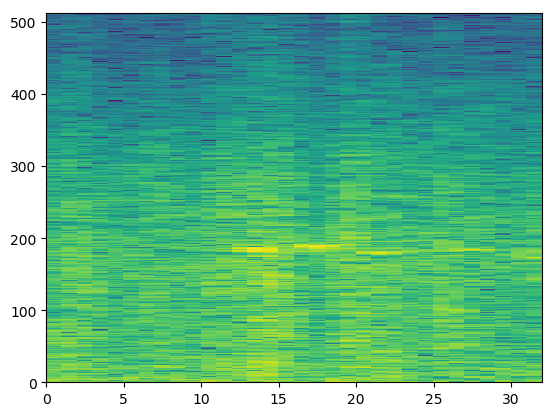

In [9]:
for i in 1:30
    figure()
    pcolormesh(data_array[:,:,1,i])
end

In [10]:
layer = Flux.Conv((3,3), 1=>16, pad=(1,1),relu)
trainx = reshape(data_array[:,:,1,1], size(data_array[:,:,1,1])...,1,1)
trainx512 = trainx[1:end-1,:,:,:]
layer(trainx)

Tracked 513×32×16×1 Array{Float32,4}:
[:, :, 1, 1] =
 0.338537  0.690642   0.7204     …  0.720549   0.722834   0.496176 
 0.0       0.397471   0.347116      0.280039   0.305959   0.313164 
 0.0       0.249899   0.295722      0.269817   0.29179    0.279491 
 0.0       0.255482   0.241864      0.252418   0.317606   0.325642 
 0.0       0.239287   0.249012      0.303938   0.309257   0.313249 
 0.0       0.25972    0.225849   …  0.281159   0.277454   0.227944 
 0.0       0.312093   0.191853      0.139305   0.152578   0.24167  
 0.0       0.215216   0.273441      0.229971   0.263202   0.245771 
 0.0       0.430401   0.286464      0.192802   0.272027   0.328411 
 0.0       0.303814   0.276467      0.340131   0.298546   0.314504 
 0.0       0.327324   0.261224   …  0.325913   0.222776   0.29784  
 0.0       0.284596   0.285055      0.225544   0.274005   0.289317 
 0.0       0.267539   0.302566      0.36503    0.222097   0.277255 
 ⋮                               ⋱             ⋮               

In [11]:
function update(model, optimiser)
    for p in params(model)
        Δ = Flux.Optimise.apply!(optimiser, p.data, p.grad)
        p.data .-= Δ
        Δ .= 0
    end
end

update (generic function with 1 method)

### Since ConvTranspose does not work, lets try uspcaling

In [12]:
function honeszeros(T,segment,length,i)
    res = zeros(T,1,segment*length)
    res[((i-1)*segment+1):i*segment] = ones(T,1,segment)
    return res
end
function voneszeros(T,segment,length,i)
    res = zeros(T,segment*length)
    res[((i-1)*segment+1):i*segment] = ones(T,segment)
    return res
end

voneszeros (generic function with 1 method)

In [13]:
@time honeszeros(Float32,2,3,3)
@time voneszeros(Float32,2,3,3)

  0.106683 seconds (219.01 k allocations: 11.150 MiB, 7.78% gc time)
  0.035374 seconds (87.52 k allocations: 4.362 MiB)


6-element Array{Float32,1}:
 0.0
 0.0
 0.0
 0.0
 1.0
 1.0

In [14]:
hscalemat(T,scale,n) = vcat([honeszeros(T,scale,n,i) for i in 1:n]...)
vscalemat(T,scale,n) = hcat([voneszeros(T,scale,n,i) for i in 1:n]...)

vscalemat (generic function with 1 method)

In [15]:
@time hscalemat(Float32, 2, 3)
@time vscalemat(Float32, 2, 2)

  0.228467 seconds (684.95 k allocations: 34.319 MiB, 6.46% gc time)
  0.129482 seconds (515.53 k allocations: 25.483 MiB, 5.30% gc time)


4×2 Array{Float32,2}:
 1.0  0.0
 1.0  0.0
 0.0  1.0
 0.0  1.0

In [16]:
x = randn(Float32,2,3)
vscalemat(Float32,4,2)*x*hscalemat(Float32,2,3)

8×6 Array{Float32,2}:
 1.14078   1.14078    0.792141   0.792141  -0.488467  -0.488467
 1.14078   1.14078    0.792141   0.792141  -0.488467  -0.488467
 1.14078   1.14078    0.792141   0.792141  -0.488467  -0.488467
 1.14078   1.14078    0.792141   0.792141  -0.488467  -0.488467
 0.234372  0.234372  -0.780184  -0.780184  -0.355021  -0.355021
 0.234372  0.234372  -0.780184  -0.780184  -0.355021  -0.355021
 0.234372  0.234372  -0.780184  -0.780184  -0.355021  -0.355021
 0.234372  0.234372  -0.780184  -0.780184  -0.355021  -0.355021

In [106]:
"""
    upscale(x::AbstractArray, scale)

Upscale a 2D array by the integer number given in scale tuple. Works
even for 3D and 4D array in the first two dimensions.
"""
function upscale(x::AbstractArray{T,2}, scale) where T
    m,n = size(x)
    V = vscalemat(T,scale[1],m)
    H = hscalemat(T,scale[2],n)
    return V*x*H
end
function upscale(x::AbstractArray{T,3}, scale) where T
    M,N,C = size(x)
    # this is important - the array must be of the same type as x, not T
    res = Array{typeof(x[1]),3}(undef,M*scale[1],N*scale[2],C)
    for c in 1:C
        res[:,:,c] = upscale(x[:,:,c],scale)
    end
    return Tracker.collect(res)
end
function upscale(x::AbstractArray{T,4}, scale) where T
    M,N,C,K = size(x)
    # this is important - the array must be of the same type as x, not T
    res = Array{typeof(x[1]),4}(undef,M*scale[1],N*scale[2],C,K)
    for c in 1:C
        for k in 1:K
            res[:,:,c,k] = upscale(x[:,:,c,k],scale)
        end
    end
    return Tracker.collect(res)
end

upscale (generic function with 3 methods)

In [89]:
layer = Flux.Conv((1,1),1=>1)
a = randn(3,2,1,1)
b = layer(a)

Tracked 3×2×1×1 Array{Float32,4}:
[:, :, 1, 1] =
  0.151466   -0.0326112
  0.0108867  -0.137628 
 -0.185446    0.307319 

In [99]:
@time upscale(b[:,:,1,1],(2,3))

  0.024407 seconds (8.86 k allocations: 476.922 KiB)


Tracked 6×6 Array{Float32,2}:
  0.151466    0.151466    0.151466   -0.0326112  -0.0326112  -0.0326112
  0.151466    0.151466    0.151466   -0.0326112  -0.0326112  -0.0326112
  0.0108867   0.0108867   0.0108867  -0.137628   -0.137628   -0.137628 
  0.0108867   0.0108867   0.0108867  -0.137628   -0.137628   -0.137628 
 -0.185446   -0.185446   -0.185446    0.307319    0.307319    0.307319 
 -0.185446   -0.185446   -0.185446    0.307319    0.307319    0.307319 

In [107]:
@time upscale(b[:,:,:,1],(2,3))

  0.043589 seconds (59.09 k allocations: 3.047 MiB)


Tracked 6×6×1 Array{Float32,3}:
[:, :, 1] =
  0.151466    0.151466    0.151466   -0.0326112  -0.0326112  -0.0326112
  0.151466    0.151466    0.151466   -0.0326112  -0.0326112  -0.0326112
  0.0108867   0.0108867   0.0108867  -0.137628   -0.137628   -0.137628 
  0.0108867   0.0108867   0.0108867  -0.137628   -0.137628   -0.137628 
 -0.185446   -0.185446   -0.185446    0.307319    0.307319    0.307319 
 -0.185446   -0.185446   -0.185446    0.307319    0.307319    0.307319 

In [101]:
@time upscale(b,(2,3))

  0.042083 seconds (59.51 k allocations: 3.034 MiB)


6×6×1×1 Array{Tracker.TrackedReal{Float32},4}:
[:, :, 1, 1] =
  0.151466    0.151466    0.151466   -0.0326112  -0.0326112  -0.0326112
  0.151466    0.151466    0.151466   -0.0326112  -0.0326112  -0.0326112
  0.0108867   0.0108867   0.0108867  -0.137628   -0.137628   -0.137628 
  0.0108867   0.0108867   0.0108867  -0.137628   -0.137628   -0.137628 
 -0.185446   -0.185446   -0.185446    0.307319    0.307319    0.307319 
 -0.185446   -0.185446   -0.185446    0.307319    0.307319    0.307319 

### backprop through upscale

In [112]:
X = randn(Float32,24,24,1,1);

In [194]:
model = Flux.Chain(
    # 24x24x2x1
    Flux.Conv((3,3), 1=>4, pad=(1,1)),
    # 24x24x4x1
    x->maxpool(x,(3,2)),
    # 8x12x4x1
    Flux.Conv((3,3), 4=>8, pad=(1,1)),
    # 8x12x8x1
    x->maxpool(x,(2,2)),
    # 4x6x8x1
    x->reshape(x,:,size(x,4)),
    # 192x1
    Flux.Dense(192,64,relu),
    # 64x1
    Flux.Dense(64,192),
    # 192x1
    x->reshape(x,4,6,8,:),
    # 4x6x8x1
    x->upscale(x,(3,2)),
    # 12x12x8x1
    Flux.Conv((3,3), 8=>4, pad=(1,1)),
    # 12x12x4x1
    x->upscale(x,(2,2)),
    # 24x24x4x1
    Flux.Conv((3,3), 4=>1, pad=(1,1))
    # 24x24x1x1
)

Chain(Conv((3, 3), 1=>4), getfield(Main, Symbol("##125#131"))(), Conv((3, 3), 4=>8), getfield(Main, Symbol("##126#132"))(), getfield(Main, Symbol("##127#133"))(), Dense(192, 64, NNlib.relu), Dense(64, 192), getfield(Main, Symbol("##128#134"))(), getfield(Main, Symbol("##129#135"))(), Conv((3, 3), 8=>4), getfield(Main, Symbol("##130#136"))(), Conv((3, 3), 4=>1))

In [209]:
Y=model(X)

Tracked 24×24×1×1 Array{Float32,4}:
[:, :, 1, 1] =
 -0.692188   -1.52945     0.711823   …   0.896986    0.726514  -0.626307  
 -0.707295    0.148457    0.627616       1.90691    -0.11091    0.606965  
 -2.36241     0.312491   -0.310616      -0.150946    0.240092  -1.042     
  1.165      -0.0500855   0.455008       0.0304362  -1.10896    0.00305825
  0.439622    1.02631     0.117776      -1.93094     0.492192   0.132637  
  0.522909   -1.20596    -0.732828   …   1.18331    -0.471904   0.704108  
 -0.721776   -1.72731     1.64833       -0.205638    1.37047   -0.649512  
  1.11649    -0.476019    0.0615937     -0.441867   -0.333168   1.06302   
 -1.26036     0.868265   -0.854646       0.269865    0.367909   1.77102   
  0.452074    0.0931113  -0.629817      -0.0196885  -0.877395   1.15382   
  1.38329    -1.42403     1.34854    …   1.79587     1.20789   -0.463517  
  1.16356     0.0787939   0.968426      -0.19667    -0.851988   0.952716  
 -0.486302    0.415001   -1.01224        1.30898 

In [210]:
X

24×24×1×1 Array{Float32,4}:
[:, :, 1, 1] =
 -0.614493   -1.82646      0.923356   …   0.813866   0.957897   -0.691693 
 -0.908408    0.0780402    0.888539       1.3978     0.130893    0.373124 
 -2.21691     0.205869    -0.14358        0.180812   0.274243   -0.891279 
  1.89248    -0.0361055    1.00917       -0.209444  -1.43359    -0.103315 
 -0.237125    0.373209     0.17059       -1.63937    0.288109    0.66324  
  0.450356   -1.16171     -0.74565    …   1.18111   -0.344717    0.0842193
 -0.746492   -1.8718       1.44474       -0.284331   1.58632    -0.607702 
  1.8918     -0.440771    -0.543365      -0.611309  -0.338818    0.875848 
 -1.42313     1.42094     -0.99402        0.67669    0.297809    2.27617  
 -0.0148648   0.303938    -0.82128       -0.329324  -1.15734     0.931512 
  1.27222    -1.3391       1.61862    …   2.04245    1.40598    -0.392278 
  1.06678    -0.00445282   0.998673      -0.413901  -0.81272     0.825406 
 -0.292323    0.46881     -1.01788        1.41841    0.19

In [196]:
loss(x) = Flux.mse(model(x),x)
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [200]:
@time L = loss(X)

  0.001118 seconds (18.58 k allocations: 894.109 KiB)


81.05653f0 (tracked)

In [201]:
@time Flux.back!(L)
@time update(model, opt)

  0.004298 seconds (14.79 k allocations: 6.792 MiB)
  0.000689 seconds (701 allocations: 219.828 KiB)


In [208]:
@time for i in 1:5000
    L=loss(X)
    Flux.back!(L)
    update(model,opt)
    if i%500==0
        println(L)
    end
end

0.10146205f0 (tracked)
0.101375364f0 (tracked)
0.101265796f0 (tracked)
0.10112743f0 (tracked)
0.10095312f0 (tracked)
0.100734405f0 (tracked)
0.100460805f0 (tracked)
0.10011951f0 (tracked)
0.09969837f0 (tracked)
0.09924859f0 (tracked)
 29.445446 seconds (170.32 M allocations: 38.474 GiB, 25.86% gc time)


In [207]:
opt.eta=0.0001

0.0001

### does backpropagation through cat work? - yes

In [12]:
X = randn(3,4)
layer = Flux.Dense(3,2)
f(x) = cat(x,zeros(1,size(x,2)),dims=1)
catloss(x) = Flux.mse(f(layer(x)),x)
opt = ADAM()
f(layer(X))

Tracked 3×4 Array{Float64,2}:
 0.187361  -0.501445   1.28651  0.211192 
 0.364074   0.735933  -1.11517  0.0114434
 0.0        0.0        0.0      0.0      

In [15]:
l=catloss(X)

0.7562756389557868 (tracked)

In [16]:
Flux.back!(l)
update(layer,opt)

### try the double cat backprop

In [17]:
function hpad(x::AbstractArray,width)
    M,N,C,K = size(x)
    return cat(x, zeros(typeof(x[1]), M,width,C,K),dims=2)
end
function vpad(x::AbstractArray,width)
    M,N,C,K = size(x)
    return cat(x, zeros(typeof(x[1]), width,N,C,K),dims=1)
end

vpad (generic function with 1 method)

In [18]:
function pad(x::AbstractArray{T,4},widths) where T
    M,N,C,K = size(x)
    return cat(cat(x, zeros(T, M,widths[2],C,K),dims=2), zeros(T, widths[1], N+widths[2],C,K),dims=1)
end

pad (generic function with 1 method)

In [19]:
function pad(x::AbstractArray{T,2},widths) where T
    M,N = size(x)
    return cat(cat(x, zeros(T,M,widths[2]),dims=2), zeros(T, widths[1], N+widths[2]),dims=1)
end

pad (generic function with 2 methods)

In [20]:
X = randn(Float32,3,4,1,1)
layer = Flux.Conv((2,2),1=>1)
pad(layer(X),(1,1))
doublecatloss(x) = Flux.mse(x,pad(layer(x),(1,1)))
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [25]:
l = doublecatloss(X)

0.72865367f0 (tracked)

In [26]:
Flux.back!(l)
update(layer,opt)

### backpro trough a single Conv layer works

In [110]:
layer = Flux.Conv((3,3), 1=>1, pad=(1,1))
X = randn(Float32,4,4,1,1)

4×4×1×1 Array{Float32,4}:
[:, :, 1, 1] =
  0.894853  -0.84954   -1.41116    1.11009  
 -1.87497    1.15635   -0.175045   0.123906 
  0.258318  -0.405164  -1.84037   -0.013269 
 -0.321354  -1.72111    0.540651   0.0735166

In [112]:
testloss(x) = Flux.mse(x,layer(x))
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [128]:
L= testloss(X)

5.940886f0 (tracked)

In [129]:
Flux.back!(L)
update(layer,opt)

### backprop through conv + maxpool - OK

In [148]:
layer = Flux.Chain(
    Flux.Conv((3,3), 1=>1, pad=(3,3)),
    x->maxpool(x,(2,2))
    )
X = randn(Float32,4,4,1,1)

4×4×1×1 Array{Float32,4}:
[:, :, 1, 1] =
 -0.780385   0.610959  -0.293688    0.111747
 -0.32742   -0.639451   0.0631579  -1.70995 
  0.495356  -0.306703  -1.37816    -1.04973 
 -0.256877   0.331956   0.336589    2.64996 

In [149]:
layer(X)

Tracked 4×4×1×1 Array{Float32,4}:
[:, :, 1, 1] =
 0.399929  0.670763   0.225032  0.0    
 0.129038  1.00098    2.60203   2.13025
 0.140211  0.0738788  1.56737   0.0    
 0.0       0.131312   0.0       0.0    

In [150]:
testloss(x) = Flux.mse(x,layer(x))
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [151]:
L= testloss(X)

2.6913445f0 (tracked)

In [152]:
Flux.back!(L)
update(layer,opt)

### backprop through conv + convtranspose - OK

In [153]:
layer = Flux.Chain(
    Flux.Conv((3,3), 1=>1, pad=(0,0)),
    Flux.ConvTranspose((3,3), 1=>1)
    )
X = randn(Float32,4,4,1,1)

4×4×1×1 Array{Float32,4}:
[:, :, 1, 1] =
  1.28483    -0.94146   -0.540492    1.80654 
  0.0977916   0.698383   0.13895    -1.08017 
  1.0212     -0.997449   0.0556273  -0.858902
 -0.89335    -1.13834    0.314215    1.05716 

In [156]:
layer(X)

Tracked 4×4×1×1 Array{Float32,4}:
[:, :, 1, 1] =
  0.108671    0.0615342  -0.0363189  -0.0123516
  0.3743     -0.216761   -0.280898    0.160023 
 -0.0940358   0.501788   -0.255497    0.0110132
  0.589166   -0.538257   -0.0527809   0.0559345

In [157]:
testloss(x) = Flux.mse(x,layer(x))
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [158]:
L= testloss(X)

1.0387671f0 (tracked)

In [159]:
Flux.back!(L)
update(layer,opt)

### backprop through conv + maxpool + convtranspose - OK

In [167]:
layer = Flux.Chain(
    Flux.Conv((3,3), 1=>1, pad=(0,0)),
    x->maxpool(x,(1,1)),
    Flux.ConvTranspose((3,3), 1=>1)
    )
X = randn(Float32,4,4,1,1)

4×4×1×1 Array{Float32,4}:
[:, :, 1, 1] =
  0.971898   0.39949   -1.73918   -0.763583
 -0.223664   0.492763  -0.151995  -0.16339 
  0.461108   0.215205   0.535344  -1.1111  
 -0.0742073  0.489565  -0.145048   0.898967

In [168]:
layer(X)

Tracked 4×4×1×1 Array{Float32,4}:
[:, :, 1, 1] =
  1.20202       0.858945   -0.0455281  -0.044903 
  1.1421       -0.121      -1.15013    -0.289639 
 -0.733677      0.315257    0.333586   -0.0624566
  0.000492609  -0.0950593   0.0445756   0.0414161

In [169]:
testloss(x) = Flux.mse(x,layer(x))
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [176]:
L= testloss(X)

0.65230495f0 (tracked)

In [177]:
Flux.back!(L)
update(layer,opt)

### backprop through conv + maxpool something + convtranspose - OK

In [186]:
layer = Flux.Chain(
    Flux.Conv((3,3), 1=>1, pad=(0,0)),
    x->maxpool(x,(2,2)),
    Flux.ConvTranspose((2,2), 1=>1, pad=(-1,-1))
    )
X = randn(Float32,4,4,1,1)

4×4×1×1 Array{Float32,4}:
[:, :, 1, 1] =
 -0.777273   1.92973      1.71495    -0.703874
 -0.427421  -0.548033     0.281942    0.879127
  0.524909   0.462005     0.0923466  -1.77045 
 -0.610828  -0.00882804  -0.560541   -0.2311  

In [187]:
layer(X)

Tracked 4×4×1×1 Array{Float32,4}:
[:, :, 1, 1] =
 0.0   0.0        0.0       0.0
 0.0  -0.405881  -0.250511  0.0
 0.0   0.188642   0.172308  0.0
 0.0   0.0        0.0       0.0

In [188]:
testloss(x) = Flux.mse(x,layer(x))
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [189]:
L= testloss(X)

0.8284846f0 (tracked)

In [190]:
Flux.back!(L)
update(layer,opt)

### now put it all together with some dense layersin between

In [198]:
# this model works well
model = Flux.Chain(
    Flux.Conv((3,3), 1=>1, pad=(0,0)),
    x->maxpool(x,(2,2)),
    Flux.ConvTranspose((2,2), 1=>1, stride=(2,2), pad=(-1,-1))
)

Chain(Conv((3, 3), 1=>1), getfield(Main, Symbol("##95#96"))(), ConvTranspose((2, 2), 1=>1))

In [207]:
# this one too
model = Flux.Chain(
    Flux.Conv((3,3), 1=>1, pad=(0,0)),
    x->maxpool(x,(2,2)),
    Flux.ConvTranspose((3,3), 1=>1, stride=(2,2), pad=(0,0)),
    x->pad(x, (1,1))
)

Chain(Conv((3, 3), 1=>1), getfield(Main, Symbol("##101#103"))(), ConvTranspose((3, 3), 1=>1), getfield(Main, Symbol("##102#104"))())

In [220]:
# this one too
model = Flux.Chain(
    Flux.Conv((3,3), 1=>2, pad=(0,0)),
    x->maxpool(x,(2,2)),
    Flux.ConvTranspose((3,3), 2=>1, stride=(2,2), pad=(0,0)),
    x->pad(x, (1,1))
)

Chain(Conv((3, 3), 1=>2), getfield(Main, Symbol("##105#107"))(), ConvTranspose((3, 3), 2=>1), getfield(Main, Symbol("##106#108"))())

In [ ]:
# 
model = Flux.Chain(
    Flux.Conv((3,3), 1=>2, pad=(0,0)),
    x->maxpool(x,(2,2)),
    x->reshape(x,:,size(x,4)),
    x->reshape(x,)
    Flux.ConvTranspose((3,3), 2=>1, stride=(2,2), pad=(0,0)),
    x->pad(x, (1,1))
)

In [254]:
# 
model = Flux.Chain(
    Flux.Conv((3,3), 1=>2, pad=(0,0)),
    x->maxpool(x,(2,2),pad=(1,1)),
    Flux.ConvTranspose((3,3), 2=>1, stride=(2,2), pad=(1,1))
)

Chain(Conv((3, 3), 1=>2), getfield(Main, Symbol("##131#132"))(), ConvTranspose((3, 3), 2=>1))

In [255]:
model(trainx)

Tracked 511×31×1×1 Array{Float32,4}:
[:, :, 1, 1] =
 -0.103013    0.258607     -0.102534    …   0.405209    -0.162519 
 -0.554186    0.130901     -0.566986        0.07484     -0.574551 
 -0.125248    0.378646     -0.140472        0.27281     -0.0959346
 -0.540047    0.0464235    -0.567015        0.036349    -0.464408 
 -0.113039    0.247888     -0.104332        0.269961    -0.103272 
 -0.484437    0.144173     -0.419657    …   0.0714779   -0.396831 
 -0.0751467   0.184705     -0.0600442       0.169411    -0.058503 
 -0.340907    0.000638276  -0.222984        0.0313042   -0.239866 
 -0.061291    0.0305048    -0.0148127       0.100983    -0.0291622
 -0.443989    0.179719     -0.31963         0.131062    -0.369801 
 -0.120297    0.208889     -0.0893795   …   0.289008    -0.103295 
 -0.499833    0.153609     -0.363753       -0.00138003  -0.455459 
 -0.0929906   0.127685     -0.050712        0.247655    -0.0916935
  ⋮                                     ⋱                ⋮        
 -0.169742

In [236]:
Flux.Chain(
    Flux.Conv((3,3), 1=>2, pad=(0,0)),
    x->maxpool(x,(2,2),pad=(1,1)))(trainx)


Tracked 256×16×2×1 Array{Float32,4}:
[:, :, 1, 1] =
 -0.882724  -0.825647  -0.902294  …  -0.966098  -0.857326   -0.984329
 -0.876083  -0.917229  -0.865111     -0.703066  -0.738694   -0.777596
 -0.771168  -0.766898  -0.717652     -0.626976  -0.699875   -0.813195
 -0.629779  -0.614699  -0.625199     -0.676291  -0.574238   -0.494508
 -0.674004  -0.507376  -0.703241     -0.517051  -0.526437   -0.58124 
 -0.714712  -0.674058  -0.589421  …  -0.630791  -0.623744   -0.689528
 -0.647776  -0.512368  -0.610519     -0.66917   -0.69193    -0.633844
 -0.619215  -0.689332  -0.643213     -0.634538  -0.59419    -0.627129
 -0.598116  -0.500306  -0.574948     -0.643723  -0.685455   -0.564006
 -0.588852  -0.617648  -0.553825     -0.742362  -0.673592   -0.641774
 -0.686297  -0.562448  -0.598712  …  -0.649557  -0.593722   -0.443798
 -0.656717  -0.610099  -0.49028      -0.707695  -0.658884   -0.684627
 -0.726986  -0.518088  -0.673932     -0.60347   -0.625572   -0.67234 
  ⋮                               ⋱   

In [222]:
testloss(x) = Flux.mse(x,layer(x))
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [225]:
L= testloss(trainx512)

0.1570758f0 (tracked)

In [226]:
Flux.back!(L)
update(layer,opt)

In [232]:
y=reshape(trainx,:,size(trainx,4))
reshape(y,513,32,1,1)

513×32×1×1 Array{Float32,4}:
[:, :, 1, 1] =
 0.663635  0.668538  0.780937  0.742203  …  0.788395   0.751328  0.760222
 0.776931  0.775509  0.817114  0.789334     0.774319   0.669122  0.714813
 0.755251  0.714644  0.761086  0.792993     0.684835   0.635495  0.631925
 0.552943  0.641348  0.702045  0.689591     0.613899   0.636472  0.664564
 0.556904  0.586465  0.645707  0.60205      0.621867   0.645436  0.658459
 0.603704  0.578937  0.505096  0.590238  …  0.658183   0.644998  0.615281
 0.637106  0.597361  0.568225  0.549086     0.570373   0.449127  0.496326
 0.538927  0.346621  0.566582  0.44403      0.48766    0.537407  0.517373
 0.631566  0.601969  0.621385  0.624781     0.422694   0.541221  0.617342
 0.668043  0.576673  0.591103  0.608533     0.550937   0.625328  0.659084
 0.666552  0.601956  0.553001  0.576129  …  0.62716    0.65498   0.639025
 0.650878  0.589993  0.550763  0.591058     0.477591   0.617105  0.570235
 0.563338  0.572199  0.572101  0.610741     0.631756   0.61572   0.5

### Lets try autoencoders

In [122]:
encoder = Flux.Chain(
    Flux.Conv((3,3), 1=>8, pad=(1,1),relu),
    x->maxpool(x,(4,1)),
    
    Flux.Conv((3,3), 8=>16, pad=(1,1), relu),
    x->maxpool(x,(4,2)),
    
    Flux.Conv((3,3), 16=>32, pad=(1,1), relu),
    x->maxpool(x,(4,2)),
    
    x->reshape(x,:,size(x,4)),
    
    Flux.Dense(2048, 16)
)

Chain(Conv((3, 3), 1=>8, NNlib.relu), getfield(Main, Symbol("##39#43"))(), Conv((3, 3), 8=>16, NNlib.relu), getfield(Main, Symbol("##40#44"))(), Conv((3, 3), 16=>32, NNlib.relu), getfield(Main, Symbol("##41#45"))(), getfield(Main, Symbol("##42#46"))(), Dense(2048, 16))

In [28]:
y = encoder(trainx);
#_y = y[1:Int(size(y,1)/2),:];
size(y)

(128, 32, 8, 1)

In [133]:
decoder = Flux.Chain(
    Flux.Dense(16,2048,relu),
    x-> reshape(x,8,8,32,size(x,2)),
    
    Flux.ConvTranspose((3,3), 32=>16, stride=(4,2),pad=(0,1)),
    x->pad(x,(1,1)),
    Flux.ConvTranspose((3,3), 16=>8, stride=(4,2),pad=(0,1)),
    x->pad(x,(1,1)),
    Flux.ConvTranspose((3,3), 8=>1, stride=(4,1),pad=(0,1)),
    x->pad(x,(1,0)),
    Flux.ConvTranspose((3,3), 1=>1, stride=(1,1),pad=(1,1))
)

Chain(Dense(16, 2048, NNlib.relu), getfield(Main, Symbol("##55#59"))(), ConvTranspose((3, 3), 32=>16), getfield(Main, Symbol("##56#60"))(), ConvTranspose((3, 3), 16=>8), getfield(Main, Symbol("##57#61"))(), ConvTranspose((3, 3), 8=>1), getfield(Main, Symbol("##58#62"))(), ConvTranspose((3, 3), 1=>1))

In [133]:
loss(x) = Flux.mse(x,model(x))
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [134]:
L = loss(trainx2)

0.18356588f0 (tracked)

In [135]:
Flux.back!(L)

DimensionMismatch: DimensionMismatch("new dimensions (128, 8, 3, 3, 1) must be consistent with array size 36864")